# Conditional Wesserstein GAN 

## Objective

Train a neural network to generate configuration samples to produce collision simulations in the Simulator of Urban Mobility SUMO. 


In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import re
from collections import Counter

torch.manual_seed(10061999)

In [2]:
os.chdir("Scenarios/4Ways1LaneRegulated")

## Hyperparameters specification

In [3]:
batch_size = 4 
num_epochs = 50

z_size = 10
n_critic = 20
lambda_gp = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_layers = [64, 64, 64, 64]
discriminator_layers = [64, 64, 64, 64]
frames = []

## Helper functions

Sorted Alphanumeric is necessary because otherwise the file system sorts based just on numbers. 

In [4]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def convert_to_array(line):
    values = []
    for v in line.values():
        if isinstance(v, dict):
            values.extend(convert_to_array(v))
        else:
            values.append(v)
    return np.array(values)

def labels_getter():
    fp = os.getcwd()+'/labels'
    labels = []
    helper = []

    for training_slice in sorted_alphanumeric(os.listdir(os.getcwd()+'/train')): 
        if training_slice[:-4] in os.listdir(fp):
            with open(fp+'/'+training_slice[:-4], 'r') as lb:
                labels.append(convert_to_array(json.load(lb)))
                helper.append(np.nonzero(labels[-1])[0][0])

    # The folllowing code is needed to project from R18 to Rnum_classes
    # indeed we have no guarantee that all the events that may happen have actually happened. 
    # i.e. it may be that no rear rear collisions take place. 
    count = Counter(helper)
    num_classes = len(Counter(helper))

    if num_classes != 18: 
        
        converter = {}
        for key in sorted(count.keys()): 
            converter[key] = sorted(count.keys()).index(key)
        
        projected_labels = []
        for id in helper:
            projected_labels.append(nn.functional.one_hot(torch.tensor(converter[id]), num_classes))

        return num_classes, projected_labels, count, converter
    
    else: 
        return num_classes, labels, count, converter

def mapper(index):
    match index: 
        case 0: 
            return 'vehicle-vehicle frontal low'
        case 1: 
            return 'vehicle-vehicle frontal medium'
        case 2: 
            return 'vehicle-vehicle frontal high'
        case 3:
            return 'vehicle-vehicle rear low'
        case 4: 
            return 'vehicle-vehicle rear medium'
        case 5:
            return 'vehicle-vehicle rear high'
        case 6: 
            return 'vehicle-vehicle lateral low'
        case 7: 
            return 'vehicle-vehicle lateral medium'
        case 8:
            return 'vehicle-vehicle lateral high'
        case 9: 
            return 'vehicle-vehicle lateral driver low'
        case 10:
            return 'vehicle-vehicle lateral driver medium'
        case 11: 
            return 'vehicle-vehicle lateral driver high'
        case 12: 
            return 'vehicle-pedestrial low'
        case 13: 
            return 'vehicle-pedestrian medium'
        case 14: 
            return 'vehicle-pedestrian high'
        case 15: 
            return 'braking low'
        case 16: 
            return 'braking medium'
        case 17:
            return 'braking high'
            
def labels_counter(dataloader):
    # labels in training set
    classes = {}
    for _, labels in dataloader: 
        for label in labels:
            label1 = label.squeeze()
            for index in range(len(label1)): 
                if label1[index].item() == 1:
                    i = mapper(index)
                    if i in classes.keys(): 
                        classes[i] += 1
                    elif i not in classes.keys():
                        classes[i] = 0
    return classes

## Custom Dataset specification

Although we save pos xpos y angle and speed, we do not actually need the angle because the streets are themselves defining the direction of motion (it is a specific property of this road network). Moreover, we have to remember that SUMO's coordinate system has its x axis coiciding with the line splitting each lane in half. This in turn implies that we must translate both vehicles and pedestrians so that the coordinate axes coincide with the 0 x and y axes of the simulaiton itself. 

This is necessary to effectively employ the regularization term that penalizes the generator whenever the produced data does not comply with SUMO's constraints. 

In [5]:
class SUMODataset(Dataset):
    def __init__(self, filepath, label_arr):
        self.features = [np.load(filepath+f)[0] for f in sorted_alphanumeric(os.listdir(filepath)) if f[:-4] in os.listdir(os.getcwd()+'/labels')]
        self.label_arr= label_arr
        self.minmax_finder()
        self.num_vehicles = 50

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        feature =(feature - self.min)/(self.max-self.min)

        label = self.label_arr[idx]  # Assuming index corresponds to the feature file
        feature = torch.reshape(feature, (2*self.num_vehicles, 4))

        # need to take into account the displacement with respect to the center of the lanes
        feature[:self.num_vehicles, 0] = feature[:self.num_vehicles, 0] - 4.9915230274e-01 
        feature[:self.num_vehicles, 1] = feature[:self.num_vehicles, 1] - 5.0041359663e-01 
        feature[self.num_vehicles:, 0] = feature[self.num_vehicles:, 0] - .4932952821
        feature[self.num_vehicles:, 1] = feature[self.num_vehicles:, 1] - .5066891909 
        return feature[:, [0,1,3]], label

    def minmax_finder(self):

        list_min = []
        list_max = []
        for feat in self.features:
            list_min.append(torch.tensor(feat, dtype=torch.float32).min(axis=1, keepdims=True)[0])
            list_max.append(torch.tensor(feat, dtype=torch.float32).max(axis=1, keepdims=True)[0])

        stacked_tensors = torch.stack(list_min, dim=0)
        del list_min
        self.min, _ = torch.min(stacked_tensors, dim=0)

        stacked_tensors = torch.stack(list_max, dim=0)
        del list_max
        self.max, _ = torch.max(stacked_tensors, dim=0)

    def rescaler(self, tensor):
        return (self.max-self.min)*tensor+self.min

    def dimension_reducer(self):
        """
            Reduces the dimensionality of the problem by binding the vehicles to the constraints posed by the topology of the intersection.
            On a "real" application we would just save the vehicle's positions in the network in this way, but given the experimental nature of this
            research, we shall circle back.

            RETURNS THE TENSOR OF SHAPE [2, 50, 4] WHERE THE FIRST AND SECOND FEATURES OF EACH TENSOR REPRESENT A NEW ENCODING OF POSITION

        """
        for snap in self.features:
            for i in range(len(snap[0, :, :])):
                snap[0, i, 0], snap[0, i, 1] = self.encoder(snap[0, i, 0], snap[0, i, 1])
                snap[1, i, 0], snap[1, i, 1] = self.encoder(snap[1, i, 0], snap[1, i, 1], ped=True)

    def encoder(self, x, y, ped=False):
        """
            Encodes the position on x and y over the road in a categorical value
        """
        if not ped:
            # LANES
            if 0 < x < 3.20 and -1010 < y <= -7.20: # D1 LANE VEHICLE
                return y, torch.tensor(1)
            elif 0 < x < 3.20 and 7.20 <= y < 1010: # D2 LANE VEHICLE
                return y, torch.tensor(2)
            elif -3.20 < x < 0 and 7.20 <= y < 1010: # D3 LANE VEHICLE
                return y, torch.tensor(3)
            elif -3.20 < x < 0 and -1010 < y < -7.20: # D4 LANE VEHICLE
                return y, torch.tensor(4)
            elif -1010 < x < -7.20 and -3.20 < y < 0: # D5 LANE VEHCILE
                return x, torch.tensor(5)
            elif 7.20 < x < 1010 and -3.20 < y < 0: # D6 LANE VEHICLE
                return x, torch.tensor(6)
            elif -1010 < x < -7.20 and 0 < y < 3.20: # D7 LANE VEHICLE
                return x, torch.tensor(7)
            elif 7.20 < x < 1000 and 0 < y < 3.20: # D8 LANE VEHICLE
                return x, torch.tensor(8)
            # CROSSINGS
            elif -7.20 < x < -3.20 and -3.20 < y < 3.20:
                return x, torch.tensor(9)
            elif 3.20 < x < 7.20 and -3.20 < y < 3.20:
                return x, torch.tensor(10)
            elif -3.20 < x < 3.20 and -7.20 < y < -3.20:
                return y, torch.tensor(11)
            elif -3.20 < x < 3.20 and 3.20 < y < 7.20:
                return y, torch.tensor(12)
            # INTERSECTION
            elif -3.20 < x < 3.20 and -3.20 < y < 3.20:
                return x, torch.tensor(13)
            else:
                return x, y
        else:
            # LANES
            if 3.20 < x < 5.20 and -1010 < y <= -7.20: # D1 LANE PEDESTRIAN
                return y, torch.tensor(1)
            elif 3.20 < x < 5.20 and 7.20 <= y < 1010: # D2 LANE PEDESTRIAN
                return y, torch.tensor(2)
            elif -5.20 < x < -3.20 and 7.20 <= y < 1010: # D3 LANE PEDESTRIAN
                return y, torch.tensor(3)
            elif -5.20 < x < -3.20 and -1010 < y < -7.20: # D4 LANE PEDESTRIAN
                return y, torch.tensor(4)
            elif -1010 < x < -7.20 and -5.20 < y < -3.20: # D5 LANE PEDESTRIAN
                return x, torch.tensor(5)
            elif 7.20 < x < 1010 and -5.20 < y < -3.20: # D6 LANE PEDESTRIAN
                return x, torch.tensor(6)
            elif -1010 < x < -7.20 and 3.20 < y < 5.20: # D7 LANE PEDESTRIAN
                return x, torch.tensor(7)
            elif 7.20 < x < 1000 and 3.20 < y < 5.20: # D8 LANE PEDESTRIAN
                return x, torch.tensor(8)
            # CROSSINGS
            elif -7.20 < x < -3.20 and -3.20 < y < 3.20:
                return x, torch.tensor(9)
            elif 3.20 < x < 7.20 and -3.20 < y < 3.20:
                return x, torch.tensor(10)
            elif -3.20 < x < 3.20 and -7.20 < y < -3.20:
                return y, torch.tensor(11)
            elif -3.20 < x < 3.20 and 3.20 < y < 7.20:
                return y, torch.tensor(12)
            # INTERSECTION
            elif -3.20 < x < 3.20 and -3.20 < y < 3.20:
                return x, torch.tensor(13)
            else:
                return x, y

    def new_encoder(self, x, y, angle):

        if angle == 90:
            return x
        elif angle == 0:
            return y
        elif angle == 180:
            return y
        elif angle == 270:
            return x
        else:
            return x

    def new_dim_reducer(self):

        for snap in self.features:
            for i in range(len(snap[0, :, :])):
                snap[0, i, 1] = self.new_encoder(snap[0, i, 0], snap[0, i, 1], snap[0, i, 2])
                snap[1, i, 1] = self.new_encoder(snap[0, i, 0], snap[0, i, 1], snap[0, i, 2])

## Definition of the Generator/Critic networks

In [6]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size
        input_size = int(img_size/2)

        self.mixing = nn.Linear(self.z_size + class_num, generator_layer_size[0])

        self.final = nn.Linear(img_size, int(2*input_size))

        self.model_v = nn.Sequential(
            nn.Linear(generator_layer_size[0], generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], input_size)
        )


        self.model_p = nn.Sequential(
            nn.Linear(generator_layer_size[0], generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], generator_layer_size[3]), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], input_size)
        )

    def forward(self, z, labels):

        # Reshape z
        z = z.view(-1, self.z_size)
        x = torch.cat([z, labels], 1)
        x = nn.functional.leaky_relu(self.mixing(x))

        # Generator out
        out_pedestrian = self.model_p(x)
        out_vehicle = self.model_v(x)
        
        out = self.final(torch.cat([out_vehicle, out_pedestrian], 1))

        return out.view(-1, 100, 3)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, input_size, class_num):
        super().__init__()

        self.img_size = input_size
        self.model = nn.Sequential(
            nn.Linear(self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[2], discriminator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[3], discriminator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[3], discriminator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(discriminator_layer_size[3], discriminator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(discriminator_layer_size[3], discriminator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(discriminator_layer_size[3], 1)
        )

    def forward(self, x, labels):

        # Reshape fake image
        x = x.view(x.size(0), -1)
        x = torch.cat([x, labels], 1)

        # Discriminator out
        out = self.model(x)

        return out.squeeze()

## Defining Wesserstein Penalty

In [1]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, real_labels, lipschitz_penalty=False):
    batch_size = real_samples.size(0)

    alpha = torch.rand(batch_size, 1, 1).to(device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    logits = discriminator(interpolated, real_labels)
    gradients = torch.autograd.grad(logits, interpolated, grad_outputs=torch.ones_like(logits), create_graph=True)[0]

    gradients = gradients.view(batch_size, -1)

    if not lipschitz_penalty:
      # WGAN-GP Gradient Penalty for comparison
      return ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    else:
      # Lipschitz Penalty
      return (torch.clamp(gradients - 1., min=0, max=None) ** 2).mean()


def compute_constraint_penalty(fake_samples):
    """
      Computes a penalization term. For each point that is produced by the generator, we take its distance
      to the center lane. We then sum over all generated points and output the penalization error.  
    """

    transf = fake_samples[:, :, [0,1]]#
    #3 masks:
    m1 = (-transf[:, :, 0]>transf[:, :, 1])
    m2 = (transf[:, :, 0]< -transf[:, :, 1])
    m3 = ((transf[:, :, 0] < 0) & (transf[:, :, 1] < 0))

    mask = m1 | m2 | m3

    other_mask = ~mask

    lower_plane = torch.sum(torch.abs(torch.max(transf[mask], axis=1)[0]))
    upper_plane = torch.sum(torch.abs(torch.min(transf[other_mask], axis=1)[0]))

    return lower_plane + upper_plane

### Initialization and Adversarial Training


In [10]:
filepath= os.getcwd() +'/train/'
class_num, labels, counter, converter = labels_getter()

print(converter)

dataset = SUMODataset(filepath, labels)

# dealing with unbalanced classes class weights is a weight for each sample!!
class_weights = [1/class_count for class_count in counter.values()]

weights_dict = {}
for i in range(len(counter)):
  weights_dict[list(counter.keys())[i]] = 1/list(counter.values())[i]

weights = []
for label in labels:
  weights.append(weights_dict[list(converter.keys())[torch.nonzero(label).item()]])


# specifying the Sampler to be employed (we have to take into account the unbalanced data)
sampler = torch.utils.data.WeightedRandomSampler(weights, len(dataset), replacement=True)
batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, False)
dataloader = DataLoader(dataset, batch_sampler=batch_sampler)

to_plot = {}
for el in counter.keys():
    to_plot[mapper(el)] = counter[el]

print(to_plot)

{6: 0, 9: 1, 10: 2, 12: 3, 13: 4, 14: 5}
{'vehicle-pedestrian medium': 2718, 'vehicle-pedestrial low': 4509, 'vehicle-pedestrian high': 1252, 'vehicle-vehicle lateral driver medium': 6763, 'vehicle-vehicle lateral driver low': 3257, 'vehicle-vehicle lateral low': 655}


/tmp/ipykernel_3365/2598512636.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(to_plot.keys(), rotation=45)


Text(0.5, 1.0, 'Classes disstribution')

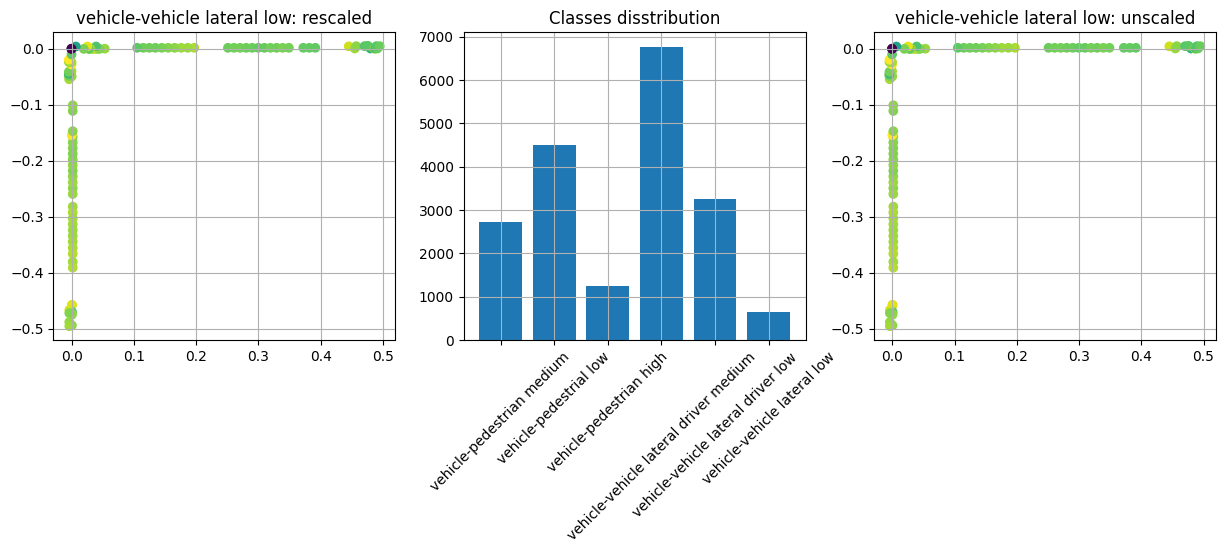

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
img, label = next(iter(dataloader))

ax1.scatter(img[0,:,0], img[0,:,1], c=img[0,:,2])
ax1.grid()
ax1.set_title(f"{mapper(list(converter.keys())[torch.nonzero(label[0]).item()])}: rescaled")

ax3.scatter(img[0,:,0], img[0,:,1], c=img[0,:,2])
ax3.grid()
ax3.set_title(f"{mapper(list(converter.keys())[torch.nonzero(label[0]).item()])}: unscaled")
# Create the second subplot
ax2.grid()
ax2.bar(to_plot.keys(), to_plot.values())
# Rotate the tick labels in the second subplot
ax2.set_xticklabels(to_plot.keys(), rotation=45)
ax2.set_title('Classes disstribution')

In [12]:
img, _ = next(iter(dataloader))
input_size = img.shape[1]*img.shape[2]

generator = Generator(generator_layers, z_size, input_size, class_num).to(device)  
discriminator = Discriminator(generator_layers, input_size, class_num).to(device)

criterion = nn.BCELoss()

generated = []
generator_loss = []
discriminator_loss = []

alpha = .005

print(len(dataset))

19154


In [13]:
print(dataset.max)
print(dataset.min)

tensor([[[ 999.8700,  995.0400,  359.9900,   17.9100]],

        [[1000.9900,  966.3600,  359.9100,    1.8300]]])
tensor([[[ -999.6800,  -999.8900,     0.0000,     0.0000]],

        [[ -966.2900, -1001.0000,     0.0000,     0.0000]]])


In [15]:
optimizer_G = optim.Adam(generator.parameters(), lr=.5e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr=.5e-5)

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=25,  gamma=0.05)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=25,  gamma=0.05)

var = torch.sqrt(torch.tensor(10))

[Epoch 0/50]  [D loss: 14586.3620] [GP: 0.8985] [G loss: 160.7317]


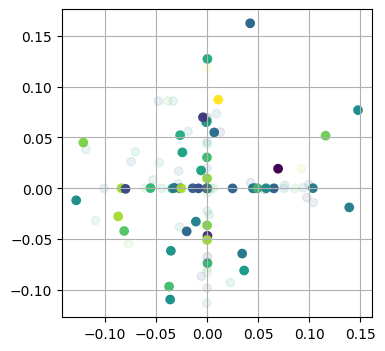

[Epoch 1/50]  [D loss: 5099.1416] [GP: 0.2636] [G loss: 57.2099]


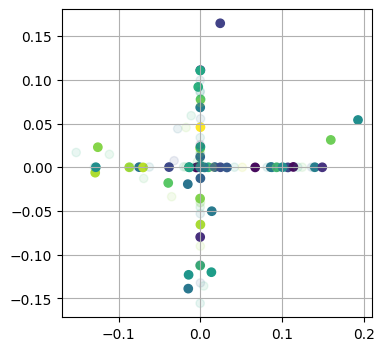

[Epoch 2/50]  [D loss: -1369.9160] [GP: 0.2416] [G loss: -4.8031]


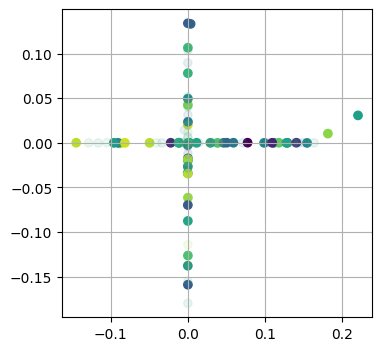

[Epoch 3/50]  [D loss: -2543.6192] [GP: 0.1735] [G loss: -15.6564]


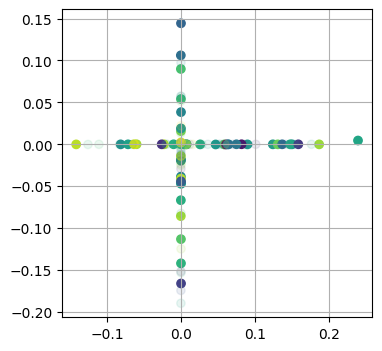

[Epoch 4/50]  [D loss: -3078.3273] [GP: 0.1749] [G loss: -13.5838]


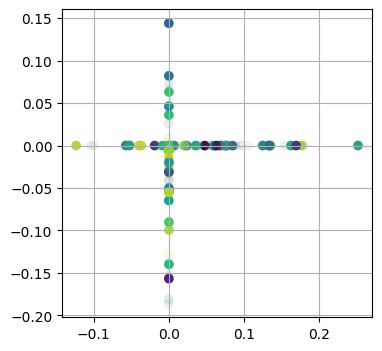

[Epoch 5/50]  [D loss: -3241.2761] [GP: 0.2101] [G loss: -15.7590]


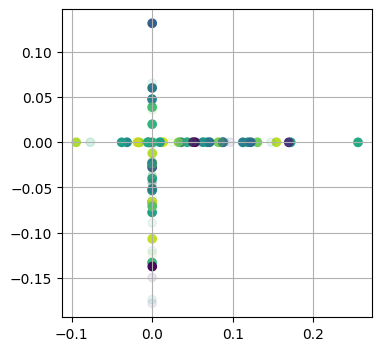

[Epoch 6/50]  [D loss: -3160.4861] [GP: 0.1553] [G loss: -17.2168]


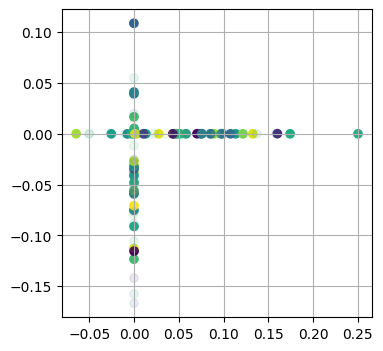

[Epoch 7/50]  [D loss: -2923.4690] [GP: 0.1615] [G loss: -10.4899]


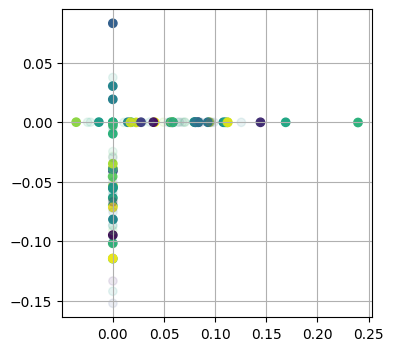

[Epoch 8/50]  [D loss: -2569.8811] [GP: 0.2311] [G loss: 13.7504]


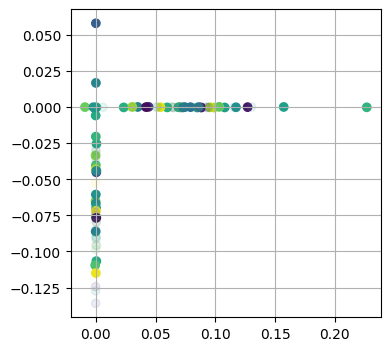

[Epoch 9/50]  [D loss: -2011.0165] [GP: 0.1076] [G loss: 52.5553]


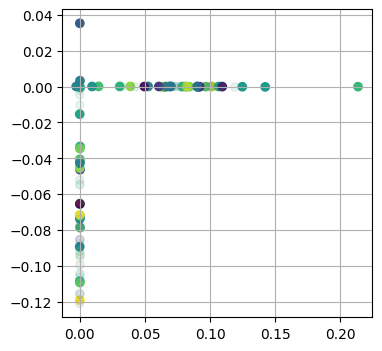

[Epoch 10/50]  [D loss: -1378.1410] [GP: 0.1474] [G loss: 95.9289]


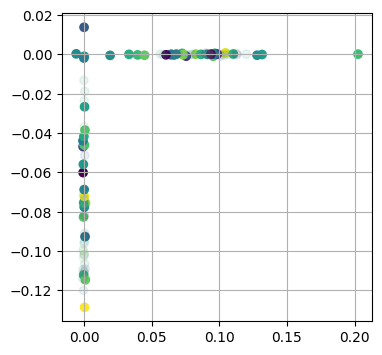

[Epoch 11/50]  [D loss: -685.0083] [GP: 0.1565] [G loss: 127.1967]


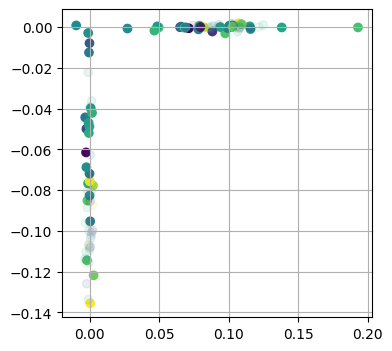

[Epoch 12/50]  [D loss: 52.4414] [GP: 0.1983] [G loss: 147.4589]


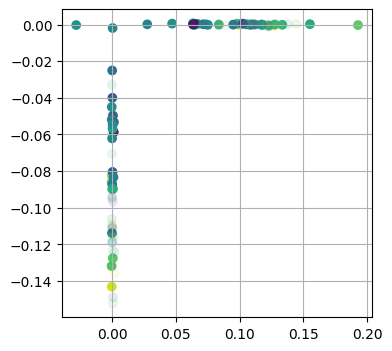

[Epoch 13/50]  [D loss: 992.4469] [GP: 0.1491] [G loss: 161.8317]


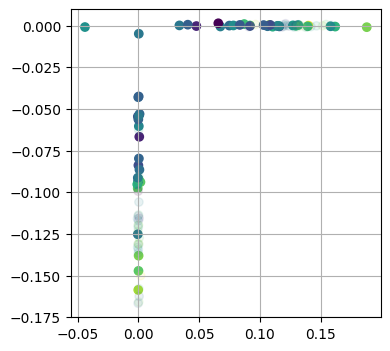

[Epoch 14/50]  [D loss: 2105.7628] [GP: 0.1664] [G loss: 216.3053]


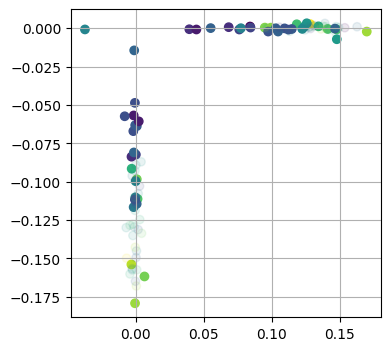

[Epoch 15/50]  [D loss: 2819.1497] [GP: 0.1900] [G loss: 464.1938]


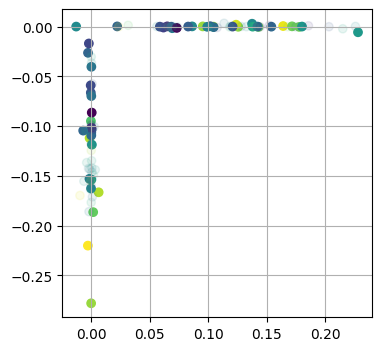

[Epoch 16/50]  [D loss: 2490.0593] [GP: 0.2163] [G loss: 734.5273]


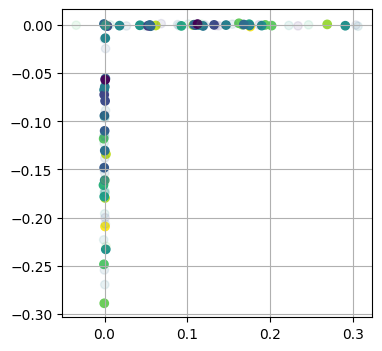

[Epoch 17/50]  [D loss: 2210.6963] [GP: 0.1954] [G loss: 758.8885]


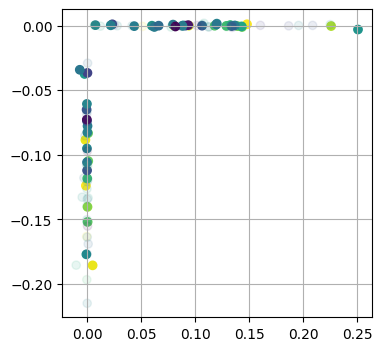

[Epoch 18/50]  [D loss: 2017.1666] [GP: 0.2065] [G loss: 685.6373]


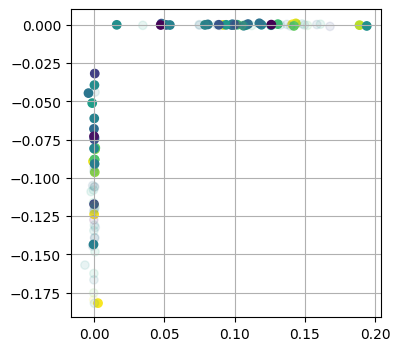

[Epoch 19/50]  [D loss: 1856.0869] [GP: 0.1550] [G loss: 589.1180]


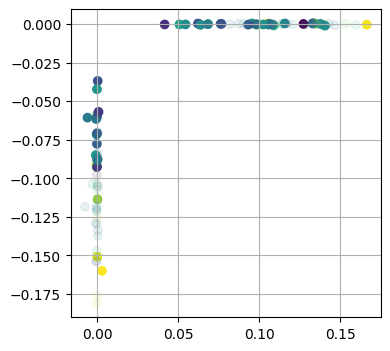

[Epoch 20/50]  [D loss: 1752.1840] [GP: 0.2006] [G loss: 476.5717]


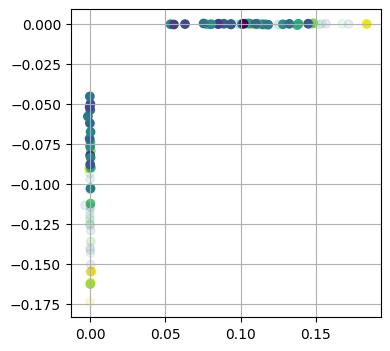

[Epoch 21/50]  [D loss: 1745.1246] [GP: 0.1907] [G loss: 395.7720]


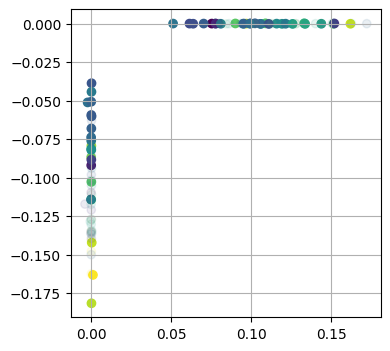

[Epoch 22/50]  [D loss: 1677.6398] [GP: 0.1494] [G loss: 363.1320]


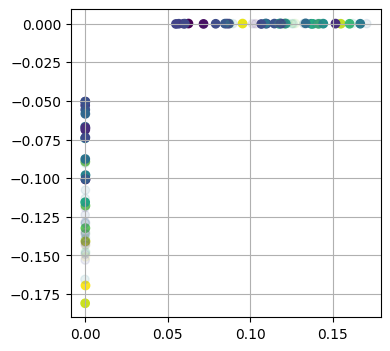

[Epoch 23/50]  [D loss: 1638.2126] [GP: 0.1533] [G loss: 350.0982]


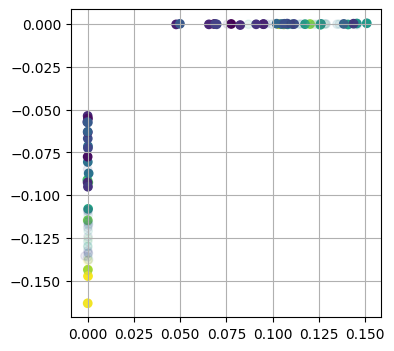

[Epoch 24/50]  [D loss: 1582.9881] [GP: 0.1192] [G loss: 330.8186]


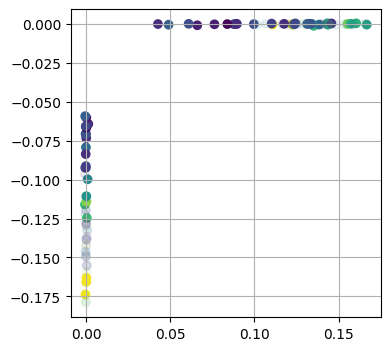

[Epoch 25/50]  [D loss: 1602.5250] [GP: 0.1504] [G loss: 314.0015]


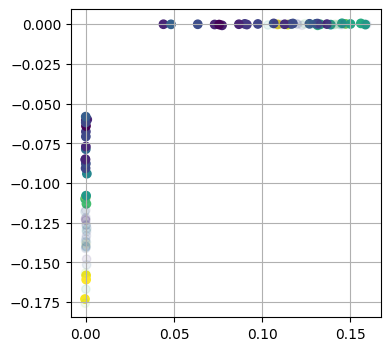

[Epoch 26/50]  [D loss: 1588.7960] [GP: 0.1849] [G loss: 314.3502]


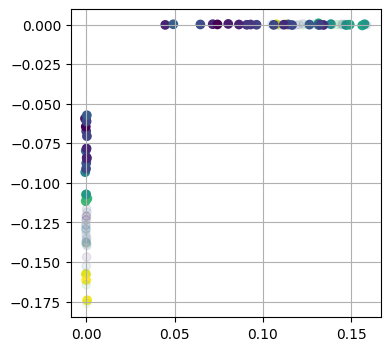

[Epoch 27/50]  [D loss: 1569.2044] [GP: 0.1656] [G loss: 312.3018]


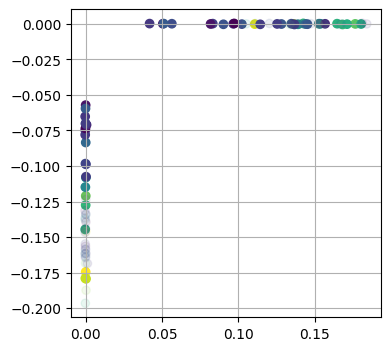

[Epoch 28/50]  [D loss: 1570.8892] [GP: 0.1595] [G loss: 310.0653]


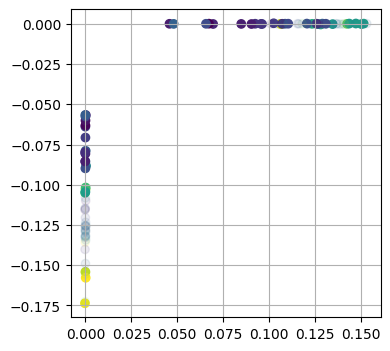

[Epoch 29/50]  [D loss: 1603.9280] [GP: 0.1927] [G loss: 303.9656]


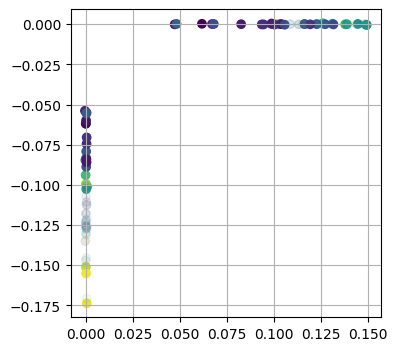

[Epoch 30/50]  [D loss: 1575.9138] [GP: 0.1962] [G loss: 306.5811]


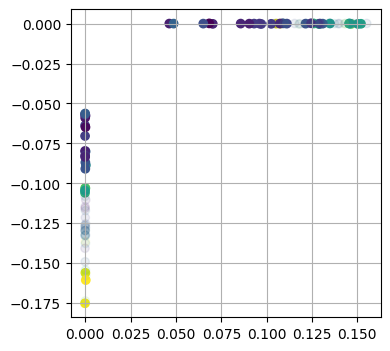

[Epoch 31/50]  [D loss: 1566.5645] [GP: 0.1838] [G loss: 307.4345]


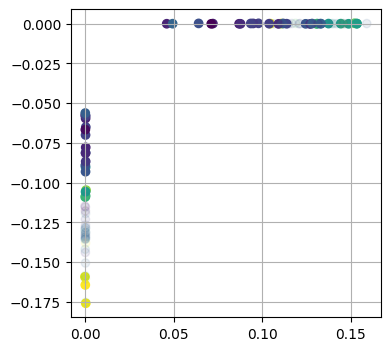

[Epoch 32/50]  [D loss: 1575.3285] [GP: 0.1620] [G loss: 303.4478]


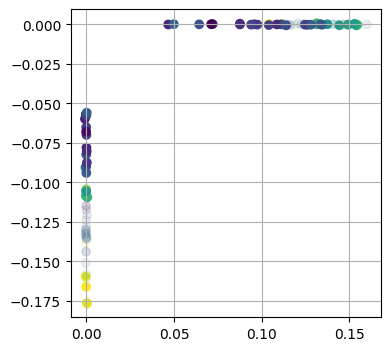

[Epoch 33/50]  [D loss: 1586.1544] [GP: 0.1528] [G loss: 305.7377]


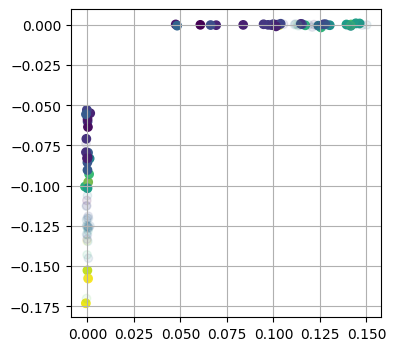

[Epoch 34/50]  [D loss: 1592.0757] [GP: 0.2269] [G loss: 300.4803]


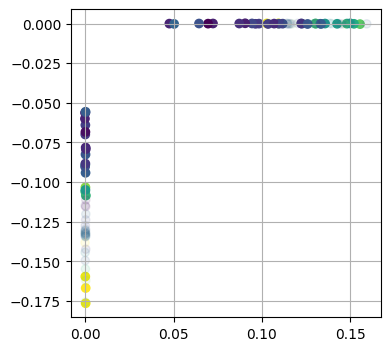

[Epoch 35/50]  [D loss: 1572.0650] [GP: 0.2214] [G loss: 295.4801]


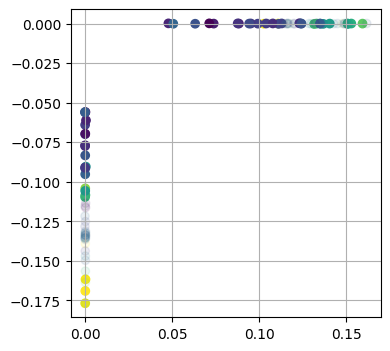

[Epoch 36/50]  [D loss: 1589.6406] [GP: 0.1603] [G loss: 294.9360]


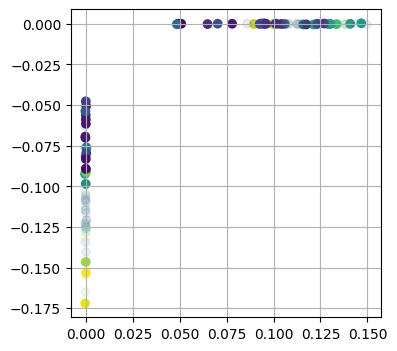

[Epoch 37/50]  [D loss: 1570.2469] [GP: 0.1600] [G loss: 297.3681]


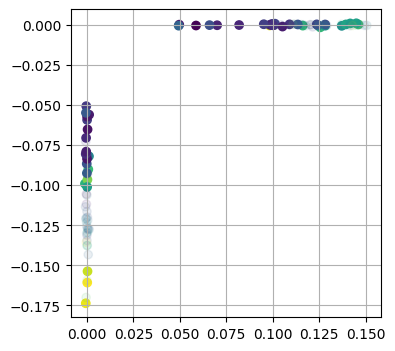

[Epoch 38/50]  [D loss: 1579.5382] [GP: 0.1517] [G loss: 294.4954]


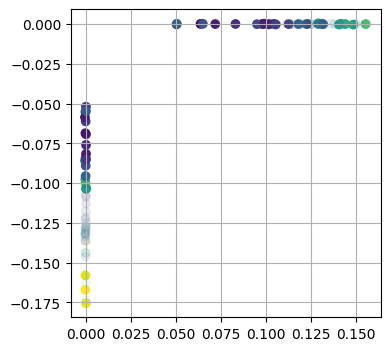

[Epoch 39/50]  [D loss: 1548.3700] [GP: 0.1795] [G loss: 292.8166]


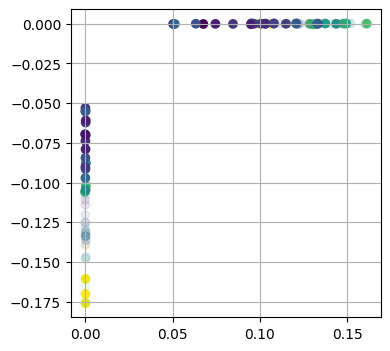

[Epoch 40/50]  [D loss: 1561.8201] [GP: 0.1806] [G loss: 289.1580]


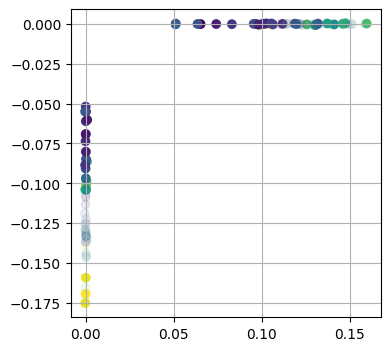

[Epoch 41/50]  [D loss: 1548.8623] [GP: 0.1560] [G loss: 287.9052]


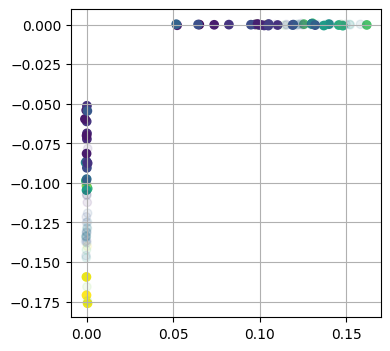

[Epoch 42/50]  [D loss: 1539.1264] [GP: 0.1860] [G loss: 290.0275]


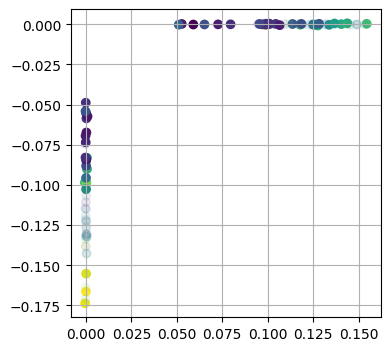

[Epoch 43/50]  [D loss: 1564.5806] [GP: 0.1282] [G loss: 284.4439]


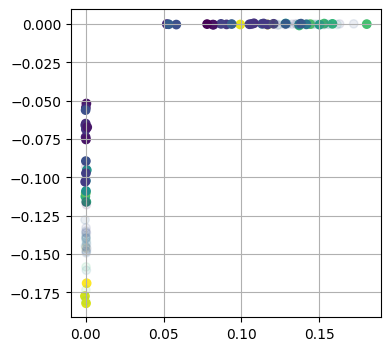

[Epoch 44/50]  [D loss: 1563.2515] [GP: 0.1326] [G loss: 283.0868]


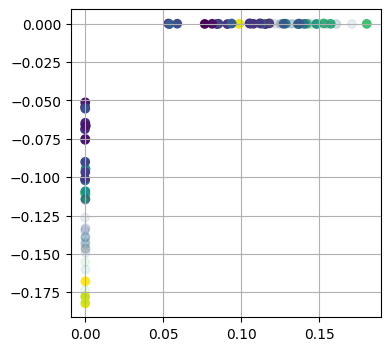

[Epoch 45/50]  [D loss: 1542.2379] [GP: 0.1576] [G loss: 285.0471]


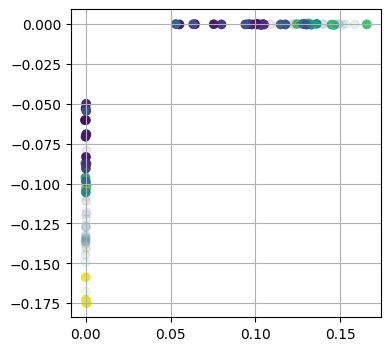

[Epoch 46/50]  [D loss: 1552.9306] [GP: 0.1586] [G loss: 285.6700]


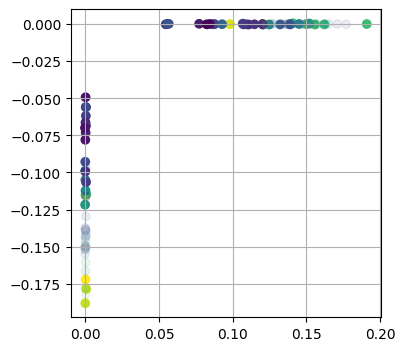

[Epoch 47/50]  [D loss: 1538.3614] [GP: 0.2062] [G loss: 282.1351]


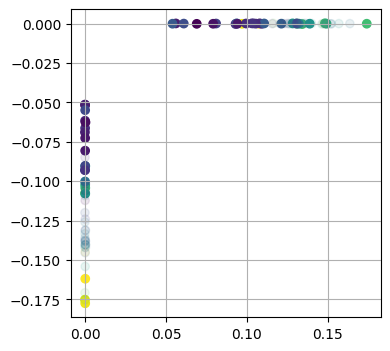

[Epoch 48/50]  [D loss: 1562.9402] [GP: 0.1941] [G loss: 279.6115]


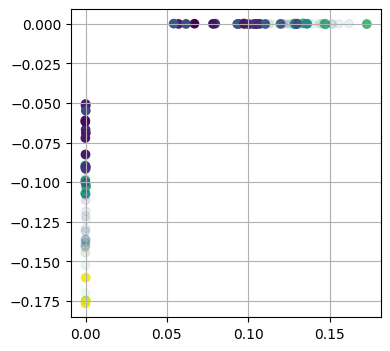

[Epoch 49/50]  [D loss: 1540.5017] [GP: 0.1956] [G loss: 282.6057]


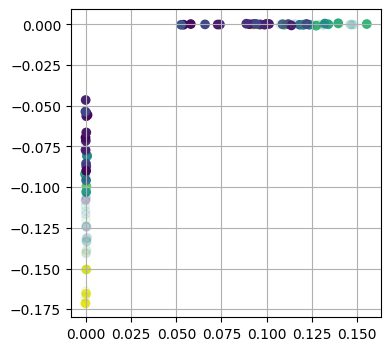

In [16]:
for epoch in range(num_epochs):

    generator.train()
    discriminator.train()

    d_loss_tot = 0
    g_loss_tot = 0

    for i, (imgs, labels) in enumerate(dataloader):
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.shape[0]

        # ---------------------
        #  Train Discriminator
        # ---------------------

        for _ in range(n_critic):

            # Calculate discriminator loss on real images
            real_out = discriminator(real_imgs, labels)
            real_loss = torch.mean(real_out)

            # Calculate discriminator loss on fake images
            # Sample noise as generator input
            z = var*torch.randn(batch_size, z_size).to(device)

            fake_imgs = generator(z, labels)
            fake_out = discriminator(fake_imgs.detach(), labels)
            fake_loss = torch.mean(fake_out)

            # Compute gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data, labels.data, False)

            # Total discriminator loss
            d_loss = fake_loss - real_loss + lambda_gp * gradient_penalty

            # Backward and optimize
            discriminator.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            #training statistics
            d_loss_tot += d_loss.detach().item()

        # -----------------
        #  Train Generator
        # -----------------

        # Sample noise as generator input
        z = var*torch.randn(batch_size, z_size).to(device)
        fake_labels = torch.LongTensor(np.random.randint(0,class_num, batch_size)).to(device)
        one_hot_labels = nn.functional.one_hot(fake_labels, class_num)

        # Generate a batch of images
        gen_imgs = generator(z, one_hot_labels)

        # discriminate
        discriminator_fake = discriminator(gen_imgs, one_hot_labels)

        # Generator loss
        # first the physically constrained part
        penalty = compute_constraint_penalty(gen_imgs)

        g_loss = -torch.mean(discriminator_fake) + alpha*penalty

        generator.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        g_loss_tot += g_loss.detach().item()

    ######

    #alpha *= 0.95
    scheduler_D.step()
    scheduler_G.step()

    print(
        "[Epoch %d/%d]  [D loss: %.4f] [GP: %.4f] [G loss: %.4f]"
        % (epoch, num_epochs, d_loss_tot, gradient_penalty.item(), g_loss_tot)
    )
    # Sample noise as generator input
    z = var*torch.randn(batch_size, z_size).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0,class_num, batch_size)).to(device)
    one_hot_labels = nn.functional.one_hot(fake_labels, class_num)
    # Generate a batch of images
    img = generator(z, one_hot_labels).detach()
    generated.append(img[0])

    #scheduler.step(g_loss)

    generator_loss.append(g_loss_tot/len(dataloader))
    discriminator_loss.append(d_loss_tot/(n_critic*len(dataloader)))


    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax.scatter(img[0, :50, 0], img[0, :50, 1], c=img[0, :50, 2])
    ax.scatter(img[0, 50:, 0], img[0, 50:, 1], c=img[0, 50:, 2], alpha=0.1)
    ax.grid()

    plt.show()

    

In [ ]:
input_names = ["White Noise", "Label"]
output_names = ["Generated Data"]
z = torch.randn(img.shape[0], z_size).to(device)

torch.onnx.export(generator, (z,label), "network.onnx", input_names=input_names, output_names=output_names)

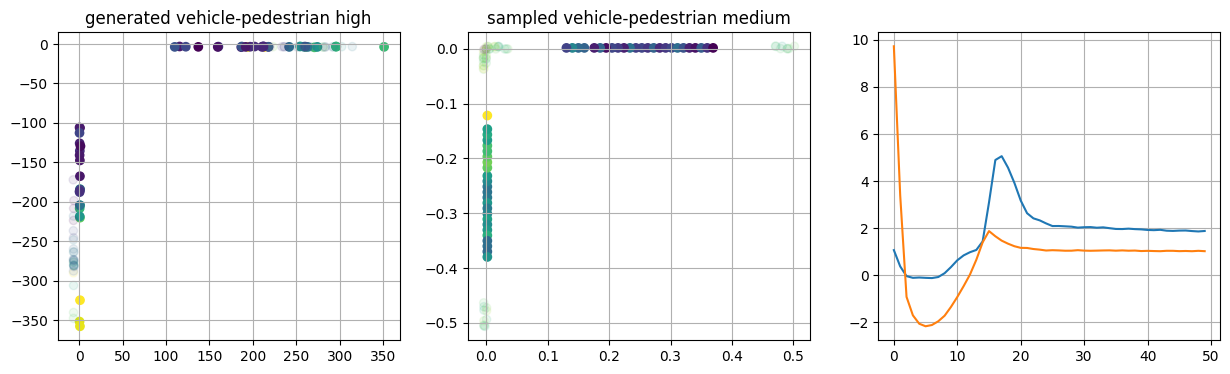

In [17]:
torch.set_printoptions(4)

num_v = 50

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
img, label = next(iter(dataloader))

z = var*torch.randn(batch_size, z_size).to(device)
fake_labels = torch.LongTensor(np.random.randint(0,class_num, batch_size)).to(device)
one_hot_labels = nn.functional.one_hot(fake_labels, class_num)
rescaled = generator(z, one_hot_labels).detach()


# img = dataset.rescaler(img[0, :, :].view(2, 50, 4))
# img = torch.reshape(img, (-1, 100, 4))

ax2.set_title(f"sampled {mapper(list(converter.keys())[torch.nonzero(label[0]).item()])}")
ax2.scatter(img[0, :num_v, 0], img[0, :num_v, 1], c=img[0, :num_v, 2])
ax2.scatter(img[0, num_v:, 0],img[0, num_v:, 1], c=img[0, num_v:, 2], alpha=0.1)
ax2.grid()

rescaled[0,:num_v, 0] += .5004
rescaled[0,:num_v, 1] += .4995
rescaled[0,num_v:, 0] += .488
rescaled[0,num_v:, 1] += .507

rescaled = torch.cat([rescaled[0, :, [0, 1]], torch.zeros((100, 1)), rescaled[0, :, [2]]], axis=1)
rescaled = dataset.rescaler(rescaled.view(2, 50, 4))
rescaled = torch.reshape(rescaled, (-1, 100,4))

ax1.set_title(f"generated {mapper(list(converter.keys())[torch.nonzero(one_hot_labels[0]).item()])}")
ax1.scatter(rescaled[0, :num_v, 0], rescaled[0, :num_v,1], c=rescaled[0, :num_v,3])
ax1.scatter(rescaled[0, num_v:, 0], rescaled[0, num_v:,1], c=rescaled[0, num_v:,3], alpha=0.1)
ax1.grid()

ax3.plot(generator_loss)
ax3.plot(discriminator_loss)
ax3.grid()

In [18]:
torch.save(generator.state_dict(), 'generator')
torch.save(discriminator.state_dict(), 'discriminator')